# Example: Basic dispersion relation calculations
This example shows basic functionalities of the SpinWaveToolkit (SWT) regarding the spin-wave (SW) dispersion relation and derived quantities: group velocity, lifetime, and decay length. The most general model is also the most commonly used one - the `SingleLayer` class. It implements the formula of Kalinikos and Slavin [*J. Phys. C: Solid State Phys.*, **19**, 7013 (1986)].

Let's start by importing needed modules and defining the problem using material parameters of the ferromagnetic layer and the propagation geometry.

In [2]:
# import modules
import numpy as np  # for vectorization
import matplotlib.pyplot as plt  # for plotting
import SpinWaveToolkit as SWT

In [ ]:
# Define material properties using custom parameters
mat = SWT.Material(
    Ms=800e3,   # (A/m) saturation magnetization
    Aex=16e-12,  # (J/m) exchange stiffness
    alpha=0.007,  # () damping
    gamma=28.8*1e9*2*np.pi  # (rad*Hz/T) gyromagnetic ratio
)
# or use built-in materials
mat = SWT.NiFe

# Define the propagation geometry
d = 100e-9  # (m) layer thickness
Bext = 50e-3  # (T) external magnetic field
theta = np.pi/2  # (rad) for in-plane magnetization
phi = np.pi/2  # (rad) for Damon-Eshbach geometry
k = np.linspace(0, 25e6, 200) + 1  # (rad/m) SW wavenumber range 
# Note the +1 above used to avoid badly conditioned calculations at k=0
bc = 1 # boundary condition (1 - totally unpinned, 2 - totally pinned spins)


Now we can calculate the dispersion relation for Damon-Eshbach SWs ($\mathbf{k}\perp \mathbf{M}$ or $\phi=\pi/2$). It's easy to also switch to backward volume geometry ($\mathbf{k}\parallel \mathbf{M}$ or $\phi=0$).

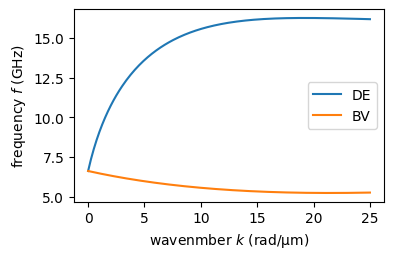

In [29]:
# Instantiate the SingleLayer class
sl = SWT.SingleLayer(Bext, mat, d, k, theta, phi, boundary_cond=bc)

f_de = sl.GetDispersion()/(2e9*np.pi)  # (GHz) DE SW dispersion
sl.phi = 0  # switch to backward volume geometry
f_bv = sl.GetDispersion()/(2e9*np.pi)  # (GHz) BV SW dispersion

fig = plt.figure(figsize=(4, 2.5))
plt.plot(k*1e-6, f_de, label="DE")
plt.plot(k*1e-6, f_bv, label="BV")
plt.xlabel(r"wavenmber $k$ (rad/µm)")
plt.ylabel(r"frequency $f$ (GHz)")
plt.legend(loc="center right")
plt.show()

To calculate higher-order perpendicular standing spin-wave (PSSW) modes, just supply the mode number to the `sl.GetDispesion()` method. *Note that this model uses just diagonal elements of the system matrix, therefore hybridizations between modes are neglected (see further).*

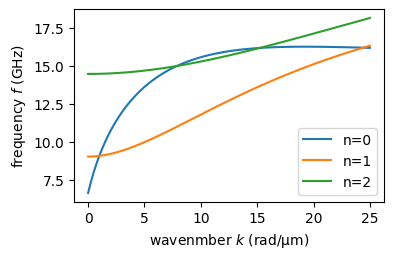

In [41]:
nmodes = 3  # number of PSSW modes to calculate
sl.phi = np.pi/2  # switch back to Damon-Eshbach geometry
fig = plt.figure(figsize=(4, 2.5))
for i in range(nmodes):
    f_de_pssw = sl.GetDispersion(i, -1)/(2e9*np.pi)  # (GHz) DE SW dispersion
    plt.plot(k*1e-6, f_de_pssw, label=f"n={i}")
plt.xlabel(r"wavenmber $k$ (rad/µm)")
plt.ylabel(r"frequency $f$ (GHz)")
plt.legend(loc="lower right")
plt.show()